<a href="https://colab.research.google.com/github/bye23mj/DACON/blob/main/jejudatahub_dacon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

In [8]:
import requests, bs4
from lxml import html
from urllib.request import Request, urlopen
from urllib.parse import urlencode, quote_plus, unquote, unquote_plus
import json

# URL 파라미터 분리하기
xmlUrl = 'https://open.jejudatahub.net/api/proxy/5D5a577taba7tbb71at1b1bt9tatata9/'
My_API_Key = unquote('5c6e67776cr657rtp1er6751cb1ooj6e')

#https://open.jejudatahub.net/api/proxy/5D5a577taba7tbb71at1b1bt9tatata9/8r7cebr7_187_1tp1c7t1to_b11co578?startDate=201601&endDate=201902

DF = pd.DataFrame()  # Dataframe to store all data
marketType_list = ['교통', '소매', '쇼핑', '숙박', '유흥', '문화/레져', '식음료']
sigungu_list = ['제주시', '서귀포시']
cityGubun_list = ['도심', '읍면']
endDate_list = ['201609','201610','201611','201612','201701','201702','201703','201704','201705','201706','201707',
                '201708','201709','201710','201711','201712','201801','201802','201803','201804','201805','201806',
                '201807','201808','201809','201810','201811','201812']

for marketType in tqdm(marketType_list):
  for sigungu in sigungu_list:
    for cityGubun in cityGubun_list:
      for endDate in endDate_list:
        queryParams = '?' + urlencode(    # get 방식으로 쿼리를 분리하기 위해 '?'를 넣은 것이다. 메타코드 아님.
            {
                quote_plus('startDate') : '201609',
                quote_plus('endDate') : endDate,
                quote_plus('sigungu') : sigungu,
                quote_plus('cityGubun'): cityGubun,
                quote_plus('userType') : '내국인관광객',
                quote_plus('marketType') : marketType
            }
        )

        response = requests.get(xmlUrl + My_API_Key + queryParams).text.encode('utf-8')
        xmlobj = bs4.BeautifulSoup(response, 'html.parser')
        xmlobj_str = str(xmlobj)
        raw_json = json.loads(xmlobj_str)
        raw_data = raw_json['data']

        for item in raw_data:
          DF = DF.append(pd.DataFrame([item])).reset_index(drop=True)

100%|██████████| 7/7 [10:39<00:00, 91.36s/it]


In [11]:
dir = '/content/Jeju Data Analysis/DATA/'
DF.to_csv(dir+'jeju_tourist_card_data.csv', encoding='utf-8', index=False)

In [13]:
DATA = pd.read_csv('/content/Jeju Data Analysis/DATA/jeju_tourist_card_data.csv')
DATA['dtYearMonth'] = pd.to_datetime(DATA['dtYearMonth'], format='%Y%m', errors='coerce').dropna()  # to datetime format
DATA['avgCost'] = round(DATA['useCost']/DATA['userCount'])  # 해당 연령대와 성별 그룹의 평균 이용금액(=총이용금액/이용고객수); 소수점 위로 올림
DATA['avgCost'] = DATA['avgCost'].astype(int)  # 데이터타입은 정수로
DATA = DATA[DATA['ageGroup']!='20대미만']  # 20대 미만은 관심 연령대가 아님

In [14]:
agg_DATA = DATA.groupby(['marketType', 'ageGroup', 'dtYearMonth']).sum()
agg_DATA['avgCost'] = round(agg_DATA['useCost']/agg_DATA['userCount'])  # 해당 이용시장과 연령대의 평균이용금액(=총이용금액/이용고객수); 소수점 위로 올림
agg_DATA['avgCost'] = agg_DATA['avgCost'].astype(int)  # 데이터타입은 정수로
agg_DATA = agg_DATA.reset_index()

In [15]:
agg_DATA

marketType ageGroup dtYearMonth  userCount  useCount     useCost  avgCost
0           교통      20대  2016-09-01      17069     19573   914534695    53579
1           교통      20대  2016-10-01      14395     16826   867898227    60292
2           교통      20대  2016-11-01      13696     16141   967987781    70677
3           교통      20대  2016-12-01      16179     19196  1248136374    77145
4           교통      20대  2017-01-01      15902     18865  1325270800    83340
..         ...      ...         ...        ...       ...         ...      ...
902         유흥    60대이상  2018-08-01        547       753    98334750   179771
903         유흥    60대이상  2018-09-01        576       789   130342650   226289
904         유흥    60대이상  2018-10-01        633       848   130031805   205421
905         유흥    60대이상  2018-11-01        694       900   135576600   195355
906         유흥    60대이상  2018-12-01        628       836   127625650   203226

[907 rows x 7 columns]

In [16]:
! pip install tslearn  # 시계열 군집분석 패키지

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 35.1 MB/s 


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
%matplotlib inline

from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans

In [18]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (45.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


In [19]:
ageGroup = list(agg_DATA['ageGroup'].unique())
ageGroup

['20대', '30대', '40대', '50대', '60대이상']

In [20]:
marketType = list(agg_DATA['marketType'].unique())
marketType

['교통', '문화/레져', '소매', '쇼핑', '숙박', '식음료', '유흥']

In [21]:
# 군집분석

km_list = []  # 모형들 저장할 리스트
pred_list = []  # 클러스터링 결과들 저장할 리스트

for market in marketType:
  avgCost_list = []  # 해당 시장의 연령대별별 평균지출액 시계열을을 담을 리스트

  for age in ageGroup:  # 연령대별로
    avgCost_list.append(list(agg_DATA[(agg_DATA['marketType']==market) & (agg_DATA['ageGroup']==age)]['avgCost']))

  X = to_time_series_dataset(avgCost_list)  # tslearn 패키지의 모델에 사용될 데이터 형태를 구축하기 위함

  km = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=10, random_state=0)  # 총 군집의 수는 2개로
  pred = km.fit_predict(X)  # 데이터에 fit을 한 후 데이터에 클러스터링을 함

  pred_list.append(pred)  # saving the result of clustering for visualization
  km_list.append(km)  # saving the trained model for visualization
  
  print(f'{market}에 대한 클러스터링 결과:\n'
        f'20대: 군집 {pred[0]} / 30대: 군집 {pred[1]} / 40대: 군집 {pred[2]} / 50대: 군집 {pred[3]} / 60대이상: 군집 {pred[4]}\n')

교통에 대한 클러스터링 결과:
20대: 군집 1 / 30대: 군집 0 / 40대: 군집 0 / 50대: 군집 0 / 60대이상: 군집 0

문화/레져에 대한 클러스터링 결과:
20대: 군집 1 / 30대: 군집 1 / 40대: 군집 1 / 50대: 군집 0 / 60대이상: 군집 0

소매에 대한 클러스터링 결과:
20대: 군집 1 / 30대: 군집 1 / 40대: 군집 1 / 50대: 군집 0 / 60대이상: 군집 0

쇼핑에 대한 클러스터링 결과:
20대: 군집 1 / 30대: 군집 1 / 40대: 군집 1 / 50대: 군집 0 / 60대이상: 군집 0

숙박에 대한 클러스터링 결과:
20대: 군집 1 / 30대: 군집 1 / 40대: 군집 0 / 50대: 군집 0 / 60대이상: 군집 0

식음료에 대한 클러스터링 결과:
20대: 군집 1 / 30대: 군집 1 / 40대: 군집 0 / 50대: 군집 0 / 60대이상: 군집 0

유흥에 대한 클러스터링 결과:
20대: 군집 1 / 30대: 군집 1 / 40대: 군집 0 / 50대: 군집 0 / 60대이상: 군집 0



In [22]:
def plot_market_agg(DATA, marketType, km, pred):
  temp = agg_DATA[agg_DATA['marketType']==marketType].reset_index(drop=True)[['dtYearMonth','ageGroup','avgCost']]  # 해당 시장의 데이터

  dtYearMonth = list(temp[temp['ageGroup']==temp['ageGroup'].unique()[0]]['dtYearMonth'].values)  # 일수를 추출
  ageGroup = ['군집 0']*len(dtYearMonth)  # 레이블 리스트의 길이가 일수와 같아야 함
  avgCost = list(km.cluster_centers_[0].ravel())  # 군집 0의 평균 시계열

  temp_df = pd.DataFrame(list(zip(dtYearMonth, ageGroup, avgCost)), columns =['dtYearMonth', 'ageGroup', 'avgCost'])
  temp = pd.concat([temp, temp_df]).reset_index(drop=True)  # 해당 시장의 데이터와 군집 0 병합

  dtYearMonth = list(temp[temp['ageGroup']==temp['ageGroup'].unique()[0]]['dtYearMonth'].values)  # 일수를 추출
  ageGroup = ['군집 1']*len(dtYearMonth)  # 레이블 리스트의 길이가 일수와 같아야 함
  avgCost = list(km.cluster_centers_[1].ravel())  # 군집 1의 평균 시계열

  temp_df = pd.DataFrame(list(zip(dtYearMonth, ageGroup, avgCost)), columns =['dtYearMonth', 'ageGroup', 'avgCost'])
  temp = pd.concat([temp, temp_df]).reset_index(drop=True)  # 해당 시장의 데이터 및 군집 0과 군집 1 병합

  # color palette; 군집 0과 군집 1의 색을 직접 지정해주기 위함
  cmap = sns.color_palette("bright")
  palette = {key:value for key,value in zip(temp['ageGroup'].unique(), cmap)}
  palette['군집 0'] = 'black'
  palette['군집 1'] = 'brown'

  # style palette; 군집 0과 군집 1 외 연령대들의 시계열은 solid line 으로 그리기 위함
  dash_list = sns._core.unique_dashes(temp['ageGroup'].unique().size+1)
  style = {key:value for key,value in zip(temp['ageGroup'].unique(), dash_list[1:])}
  style['20대'] = ''  # empty string means solid
  style['30대'] = ''
  style['40대'] = ''
  style['50대'] = ''
  style['60대이상'] = ''

  sns.set(font_scale = 1.5)
  plt.rc("font", family = "NanumGothic") # 한글깨짐 방지
  plt.figure(figsize=(20, 8))
  ax = sns.lineplot(data=temp[~temp['ageGroup'].isin(['군집 0', '군집 1'])], x="dtYearMonth", y="avgCost", 
                    hue='ageGroup', palette=palette, ci=None, style='ageGroup', dashes=style, alpha=0.4)  # alpha를 통해 색의 투명도를 조정
  sns.lineplot(data=temp[temp['ageGroup'].isin(['군집 0', '군집 1'])], x="dtYearMonth", y="avgCost", 
              hue='ageGroup', palette=palette, ci=None, style='ageGroup', dashes=style, alpha=1)  # alpha를 통해 색의 투명도를 조정
  ax.set_title(f'연령대별 {marketType}에서의 평균이용금액과 군집별 평균\n'
               f'20대: 군집 {pred[0]} / 30대: 군집 {pred[1]} / 40대: 군집 {pred[2]} / 50대: 군집 {pred[3]} / 60대이상: 군집 {pred[4]}', fontsize=20)
  plt.xticks(rotation=45, size=12, fontweight='light')
  mytime = mdates.DateFormatter('%Y-%m')  # daily
  ax.xaxis.set_major_formatter(mytime)
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  ax.set_ylabel('평균이용금액(원)');  # semicolon suppresses text output
  ax.set_xlabel('시간');  # semicolon suppresses text output
  ax.legend(title='연령대')
  sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47161 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_

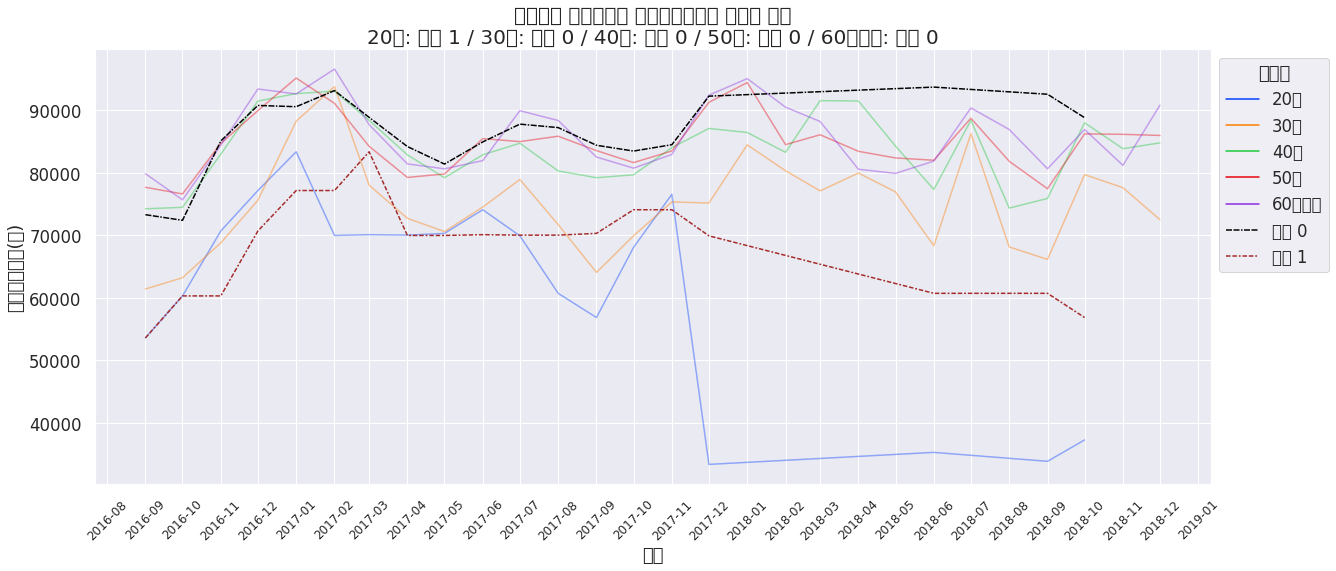

In [25]:
plot_market_agg(agg_DATA, marketType[0], km_list[0], pred_list[0])

In [ ]:
plot_market_agg(agg_DATA, marketType[1], km_list[1], pred_list[1])

In [ ]:
plot_market_agg(agg_DATA, marketType[2], km_list[2], pred_list[2])

In [ ]:
plot_market_agg(agg_DATA, marketType[3], km_list[3], pred_list[3])

In [ ]:
plot_market_agg(agg_DATA, marketType[4], km_list[4], pred_list[4])

In [ ]:
plot_market_agg(agg_DATA, marketType[5], km_list[5], pred_list[5])

In [ ]:
plot_market_agg(agg_DATA, marketType[6], km_list[6], pred_list[6])

In [24]:
# 데이터 분석 라이브러리
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
    # !pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer


# 시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import folium
from folium.plugins import MarkerCluster, MiniMap

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]


from urllib.request import Request, urlopen
from urllib.parse import urlencode, quote_plus
import json

In [27]:
bus_stops = pd.read_csv("/content/Jeju Data Analysis/DATA/bus.csv", encoding='cp949')
bus_stops

정류소아이디      정류소명          경도         위도    위치정보(주변설명)    데이터 기준일자
0     406001167.0    (구)구판장  126.798051  33.329675    세화1리노인회관입구  2022-11-01
1     406001168.0    (구)구판장  126.797879  33.329732    세화1리노인회관입구  2022-11-01
2     405000186.0  (구)삼양검문소  126.600034  33.521022       자연농원 우측  2022-11-01
3     405000185.0  (구)삼양검문소  126.600847  33.520956     조천읍이정표 좌측  2022-11-01
4     406000324.0  (구)중앙파출소  126.560894  33.247598   윤성현내과의원 건너편  2022-11-01
...           ...       ...         ...        ...           ...         ...
4075  405001116.0       흥국사  126.378405  33.452615  납읍방향.용흥3길 입구  2022-11-01
4076  406001766.0       흥덕사  126.876066  33.399128           NaN  2022-11-01
4077  406001767.0       흥덕사  126.876005  33.399031           NaN  2022-11-01
4078  406001055.0     희진주유소  126.873644  33.376610     희진주유소 건너편  2022-11-01
4079  406001056.0     희진주유소  126.874037  33.377568       희진주유소 앞  2022-11-01

[4080 rows x 6 columns]

In [28]:
loc_data = bus_stops[['위도','경도','정류소명']].drop_duplicates(keep = 'first')
loc_data = bus_stops.groupby(['정류소명'])['위도','경도'].mean()
loc_data = loc_data.reset_index()
loc_data.columns = ['stop_name', 'latitude', 'longitude']
loc_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


stop_name   latitude   longitude
0           거슨새미오름,안돌오름  33.445125  126.756875
1         남원읍 충혼묘지,물영아리  33.360190  126.692170
2      다랑쉬오름 입구(남),손지오름  33.460273  126.817124
3            동문로터리,동문시장  33.513051  126.527502
4         방선문 3차,4차 빌리지  33.487679  126.526468
...                 ...        ...         ...
2176              흙담솔사가  33.258780  126.552337
2177                 흙통  33.262151  126.582590
2178                흥국사  33.452467  126.378073
2179                흥덕사  33.399079  126.876036
2180              희진주유소  33.377089  126.873841

[2181 rows x 3 columns]

In [29]:
# 중심 지정
lat = loc_data['latitude'].mean()
long = loc_data['longitude'].mean()

map_hs = folium.Map((lat, long), zoom_start = 11)
mc = MarkerCluster()

for row in loc_data.itertuples():
    mc.add_child(folium.Marker(location = [row.latitude, row.longitude], popup = row.stop_name))
    map_hs.add_child(mc)

# map_hs.save('./bus_stops.html') 
# 파란색 표시는 한개만 있는 곳
map_hs

In [31]:
data_size = len(loc_data)

# 중심 지정
lat = loc_data['latitude'].mean()
long = loc_data['longitude'].mean()
map = folium.Map(location=[lat, long], zoom_start=11)

for i in range(data_size) : 
    folium.Circle(list(loc_data.iloc[i][['latitude', 'longitude']]),
                  radius=150,
                  color='#32408c', fill_color='#32408c').add_to(map)          

In [32]:
map

In [33]:
# 군집 개수 찾기 위해서 위/경도만 포함된 데이터 프레임 만들기
k_data = bus_stops[['위도','경도','정류소명']].drop_duplicates(keep = 'first')
k_data = bus_stops.groupby(['정류소명'])['위도','경도'].mean()
k_data = k_data.reset_index()
k_data.columns = ['stop_name', 'latitude', 'longitude']
del k_data["stop_name"]
k_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


latitude   longitude
0  33.445125  126.756875
1  33.360190  126.692170
2  33.460273  126.817124
3  33.513051  126.527502
4  33.487679  126.526468

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f364c873d10>,
                 estimator=KMeans(n_clusters=19), k=(2, 20))

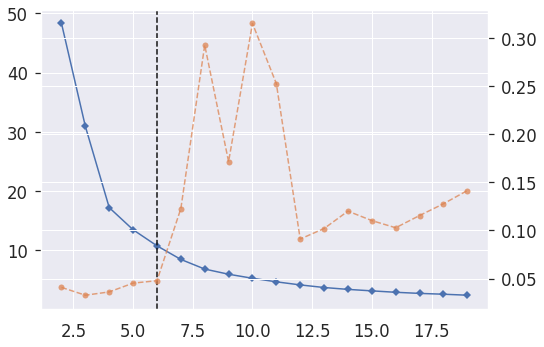

In [34]:
# 최적의 군집 개수 찾기 -> 6개
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 20), timings=True)
visualizer.fit(k_data)

In [37]:
kmeans = KMeans(n_clusters=6, random_state=np.random.RandomState(seed=1)).fit(k_data)
labels = kmeans.labels_
centers=kmeans.cluster_centers_

k_data['clustering']=labels
k_data.head()

latitude   longitude  clustering
0  33.445125  126.756875           1
1  33.360190  126.692170           4
2  33.460273  126.817124           1
3  33.513051  126.527502           2
4  33.487679  126.526468           2

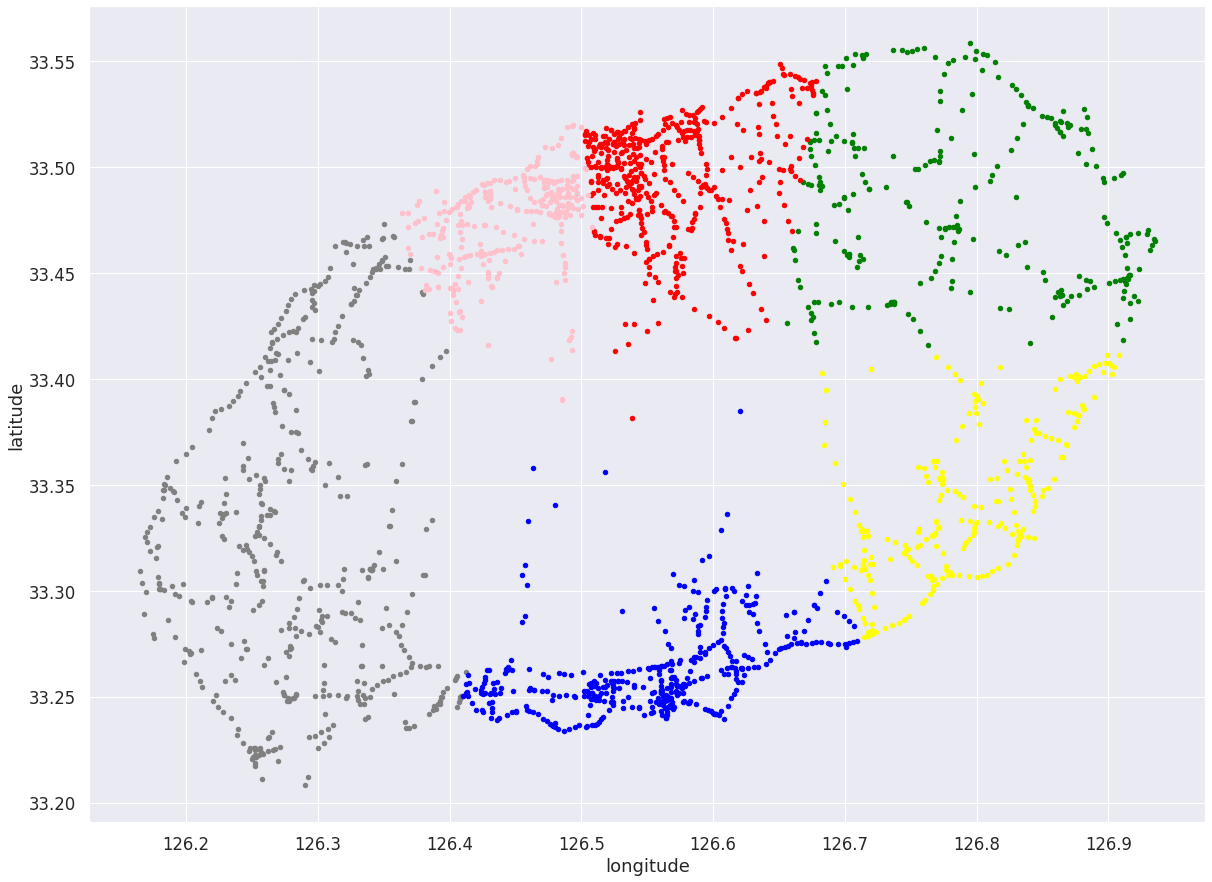

In [39]:
# 군집 시각화
fig, ax = plt.subplots(figsize=(20, 15))

df_temp = k_data[k_data['clustering']==0]
df_temp.plot.scatter(x='longitude', y='latitude', ax=ax, color='Grey')
df_temp = k_data[k_data['clustering']==1]
df_temp.plot.scatter(x='longitude', y='latitude', ax=ax, color='Green')
df_temp = k_data[k_data['clustering']==2]
df_temp.plot.scatter(x='longitude', y='latitude', ax=ax, color='Red')
df_temp = k_data[k_data['clustering']==3]
df_temp.plot.scatter(x='longitude', y='latitude', ax=ax, color='Blue')
df_temp = k_data[k_data['clustering']==4]
df_temp.plot.scatter(x='longitude', y='latitude', ax=ax, color='yellow')
df_temp = k_data[k_data['clustering']==5]
df_temp.plot.scatter(x='longitude', y='latitude', ax=ax, color='pink')

In [40]:
for i in range(6) : 
    print("군집", i, ":", len(k_data.loc[k_data['clustering'] == i]),"개")

군집 0 : 491 개
군집 1 : 273 개
군집 2 : 464 개
군집 3 : 423 개
군집 4 : 246 개
군집 5 : 284 개


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from tqdm.notebook import tqdm

In [43]:
#2020년 봄 데이터 전처리
loc2001 = pd.read_csv('/content/loc_2021_01.csv')
loc2002 = pd.read_csv('/content/loc_2021_02.csv')
loc2003 = pd.read_csv('/content/loc_2021_03.csv')

loc_spr=pd.concat([loc2001,loc2002, loc2003])
loc_spr=loc_spr[(loc_spr['latitude']<35)|(loc_spr['longitude']<130)] #outlier 제거 
loc_spr.sort_values(by=['oid','collection_dt'], inplace=True) #id, 시간별 정렬

loc_spr=loc_spr.astype({'collection_dt':'str'})
loc_spr['collection_dt']=loc_spr['collection_dt'].str[:8] #시간 데이터 변형(시,분,초 삭제)

id_spr=pd.DataFrame(loc_spr.groupby('oid').size().nlargest(100)).reset_index()['oid'] #상위 100개 id
id_spr=id_spr[id_spr!='0c0000fd'] #이상값 제거
id_spr=id_spr[id_spr!='00000000'] #이상값 제거
id_spr=pd.Series.to_numpy(id_spr)

date_spr=loc_spr['collection_dt'].unique() #날짜 추출
loc_spr=loc_spr[loc_spr['oid'].isin(id_spr)] #상위 100개 자료만 저장
loc_spr.reset_index(drop=True, inplace=True) #인덱스 초기화

In [48]:
#시각화
center=[33.3616666, 126.5291666]
m1 = folium.Map(location=center, zoom_start=11)
for i in range(99):
  x=loc_spr[loc_spr['oid']==id_spr[i]][['collection_dt','latitude','longitude']]
  groups=x.groupby(['collection_dt'])
  result=dict(list(groups))
  for j in range(len(date_spr)):
      try:
        y=pd.concat([result[date_spr[j]][['latitude']], result[date_spr[j]][['longitude']]], axis = 1)
        folium.PolyLine(locations=y, opacity=0.01, color='purple').add_to(m1)
      except:
        pass
m1        

In [47]:
#2020년 봄(1~3월) 시각화
m1

In [ ]:
#2020년 봄 데이터 전처리
loc2004 = pd.read_csv('/content/loc_2021_04.csv')
loc2005 = pd.read_csv('/content/loc_2021_05.csv')
loc2006 = pd.read_csv('/content/loc_2021_06.csv')

loc_spr=pd.concat([loc2004,loc2005, loc2006])
loc_spr=loc_spr[(loc_spr['latitude']<35)|(loc_spr['longitude']<130)] #outlier 제거 
loc_spr.sort_values(by=['oid','collection_dt'], inplace=True) #id, 시간별 정렬

loc_spr=loc_spr.astype({'collection_dt':'str'})
loc_spr['collection_dt']=loc_spr['collection_dt'].str[:8] #시간 데이터 변형(시,분,초 삭제)

id_spr=pd.DataFrame(loc_spr.groupby('oid').size().nlargest(100)).reset_index()['oid'] #상위 100개 id
id_spr=id_spr[id_spr!='0c0000fd'] #이상값 제거
id_spr=id_spr[id_spr!='00000000'] #이상값 제거
id_spr=pd.Series.to_numpy(id_spr)

date_spr=loc_spr['collection_dt'].unique() #날짜 추출
loc_spr=loc_spr[loc_spr['oid'].isin(id_spr)] #상위 100개 자료만 저장
loc_spr.reset_index(drop=True, inplace=True) #인덱스 초기화

In [ ]:
#시각화
center=[33.3616666, 126.5291666]
m2 = folium.Map(location=center, zoom_start=11)
for i in range(99):
  x=loc_spr[loc_spr['oid']==id_spr[i]][['collection_dt','latitude','longitude']]
  groups=x.groupby(['collection_dt'])
  result=dict(list(groups))
  for j in range(len(date_spr)):
      try:
        y=pd.concat([result[date_spr[j]][['latitude']], result[date_spr[j]][['longitude']]], axis = 1)
        folium.PolyLine(locations=y, opacity=0.01, color='purple').add_to(m1)
      except:
        pass

In [ ]:
m2

In [ ]:
import numpy as np
import pandas as pd

# 시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
import folium
from folium.plugins import MarkerCluster, MiniMap

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]

In [ ]:
contents_2022 = pd.read_csv("data/2022_contents.csv", encoding='cp949')
contents_2022.head()

In [ ]:
contents_2022.columns

In [ ]:
# 쓸만한 컬럼만 추출
con_2022 = contents_2022[["콘텐츠분류", "제목", "언어", "지번주소", "도로명주소", "위도", "경도", "평점", "조회수", "좋아요수", 
                  "리뷰수", "북마크수", "SNS공유수", "인기점수"]].copy()
# 결측치 확인
con_2022.isnull().sum()

In [ ]:
# 제목
con_2022[con_2022['제목'].isnull()]

In [ ]:
# 지번주소 확인 결과 돈가스 가게
con_2022["제목"].fillna("촵촵", inplace=True)

In [ ]:
con_2022.isnull().sum()

In [ ]:
con_2022.head()

In [ ]:
kor_con_2022 = con_2022[con_2022.언어.str.contains('국문')].reset_index(drop=True)
kor_con_2022.head()

In [ ]:
contents_2022['콘텐츠분류'].value_counts()

In [ ]:
kor_con_2022['평점'].value_counts().sort_index(ascending=False)

In [ ]:
food = kor_con_2022[kor_con_2022['콘텐츠분류']=='음식점']
food = food[food['평점'] == 5.0].reset_index(drop=True)  # 평점이 5인 가게만
food.head(10)

In [ ]:
top_food = food.sort_values('인기점수', ascending=False).reset_index(drop=True)
top_food.head()

In [ ]:
import folium

# 중심 지정

jeju_map = folium.Map(location=[33.3616666, 126.5291666], zoom_start=11)

for i in range(0, 440, 1):


  folium.Marker([top_food.iloc[i][5], top_food.iloc[i][6]], popup=top_food.iloc[i][0], icon=folium.Icon(color="red")).add_to(jeju_map)


# jeju_map.save('jeju.html')

jeju_map